# 订单薄数据处理与TWAP交易分析

本notebook实现以下功能：
1. 读取订单薄snapshot数据
2. 按10分钟区间分组（上午10:00-11:30，下午13:00-14:50，共20个区间）
3. 每个区间内每3秒记录一次snapshot
4. 统计每个区间的交易量，并计算目标下单量（交易量的1%）
5. 在每个区间上进行TWAP交易模拟和分析
6. 可视化展示分析结果

## 重要字段说明

**订单薄数据字段：**
- `volume`: 累计成交量（整数，股数）- 从开盘到当前时刻的累计交易量
- `amount`: 累计成交额（浮点数，金额）- 从开盘到当前时刻的累计交易金额
- `bid1_p`, `ask1_p`: 买一价、卖一价
- `bid1_v`, `ask1_v`: 买一量、卖一量

**区间统计字段：**
- `interval_total_volume`: 该10分钟区间的总成交量（取该区间最后一个snapshot的volume）
- `target_order_volume`: 目标下单量 = interval_total_volume × 1%
- `snapshot_count`: 该区间内的snapshot数量


## 1. 导入必要的库


In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Microsoft YahHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

print("✓ 库导入完成")


✓ 库导入完成


## 2. 读取原始订单薄数据


In [5]:
def load_orderbook_data(filename='orderbook_snapshots_20251220.parquet'):
    """
    从parquet文件读取订单薄数据
    """
    print(f"读取文件: {filename}")
    df = pd.read_parquet(filename)
    
    # 确保timestamp列是datetime类型
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    print(f"数据读取完成，共 {len(df)} 行")
    print(f"时间范围: {df['timestamp'].min()} 到 {df['timestamp'].max()}")
    print(f"\n列名: {list(df.columns)}")
    print(f"\n数据类型:\n{df.dtypes}")
    
    return df

# 读取数据
df_raw = load_orderbook_data('orderbook_snapshots_20251220.parquet')
print(f"\n数据预览:")
df_raw.head(10)
display(df_raw.head(10))


读取文件: orderbook_snapshots_20251220.parquet
数据读取完成，共 198001 行
时间范围: 2025-12-20 09:30:00 到 2025-12-20 15:00:00

列名: ['timestamp', 'symbol', 'bid1_p', 'bid1_v', 'bid2_p', 'bid2_v', 'bid3_p', 'bid3_v', 'bid4_p', 'bid4_v', 'bid5_p', 'bid5_v', 'ask1_p', 'ask1_v', 'ask2_p', 'ask2_v', 'ask3_p', 'ask3_v', 'ask4_p', 'ask4_v', 'ask5_p', 'ask5_v', 'last_price', 'volume', 'amount']

数据类型:
timestamp     datetime64[ns]
symbol                object
bid1_p               float64
bid1_v                 int64
bid2_p               float64
bid2_v                 int64
bid3_p               float64
bid3_v                 int64
bid4_p               float64
bid4_v                 int64
bid5_p               float64
bid5_v                 int64
ask1_p               float64
ask1_v                 int64
ask2_p               float64
ask2_v                 int64
ask3_p               float64
ask3_v                 int64
ask4_p               float64
ask4_v                 int64
ask5_p               float64
ask5_v      

,timestamp,symbol,bid1_p,bid1_v,bid2_p,bid2_v,bid3_p,bid3_v,bid4_p,bid4_v,bid5_p,bid5_v,ask1_p,ask1_v,ask2_p,ask2_v,ask3_p,ask3_v,ask4_p,ask4_v,ask5_p,ask5_v,last_price,volume,amount
0,2025-12-20 09:30:00.000,TEST001,100.04,5291,100.03,566,100.02,4526,100.01,5678,100.00,8422,100.06,5834,100.07,869,100.08,7049,100.09,2533,100.10,5411,100.05,52,5202.58
1,2025-12-20 09:30:00.100,TEST001,99.95,2847,99.94,2834,99.93,3105,99.92,4758,99.91,1999,99.97,9267,99.98,1367,99.99,1628,100.00,3656,100.01,3990,99.96,104,10395.60
2,2025-12-20 09:30:00.200,TEST001,99.79,7613,99.78,9655,99.77,6335,99.76,5586,99.75,7199,99.81,2712,99.82,875,99.83,8326,99.84,3252,99.85,1685,99.81,153,15269.14
3,2025-12-20 09:30:00.300,TEST001,100.11,7729,100.10,7969,100.09,6539,100.08,7992,100.07,6963,100.13,9567,100.14,8629,100.15,978,100.16,9368,100.17,4987,100.13,197,19723.81
4,2025-12-20 09:30:00.400,TEST001,99.88,2162,99.87,2668,99.86,5563,99.85,2127,99.84,2795,99.89,164,99.90,5358,99.91,5718,99.92,6836,99.93,491,99.89,255,25471.68
5,2025-12-20 09:30:00.500,TEST001,99.93,7315,99.92,2831,99.91,8254,99.90,9862,99.89,5156,99.95,2554,99.96,3940,99.97,1128,99.98,7485,99.99,602,99.95,306,30581.69
6,2025-12-20 09:30:00.600,TEST001,99.73,7821,99.72,7958,99.71,963,99.70,2890,99.69,7508,99.75,7135,99.76,5216,99.77,6119,99.78,1857,99.79,7674,99.75,352,35108.84
7,2025-12-20 09:30:00.700,TEST001,100.08,9889,100.07,9655,100.06,5550,100.05,1763,100.04,9821,100.09,2793,100.10,7492,100.11,1406,100.12,6876,100.13,5964,100.09,396,39634.01
8,2025-12-20 09:30:00.800,TEST001,99.85,763,99.84,1595,99.83,3404,99.82,3863,99.81,5332,99.89,2098,99.90,6685,99.91,1391,99.92,3681,99.93,7654,99.87,446,44543.36
9,2025-12-20 09:30:00.900,TEST001,99.95,8264,99.94,6628,99.93,5349,99.92,5272,99.91,1807,99.97,5955,99.98,5635,99.99,5031,100.00,3610,100.01,302,99.96,497,49680.74


## 3. 定义交易时间区间

- 上午时段：10:00 - 11:30（90分钟，9个10分钟区间）
- 下午时段：13:00 - 14:50（110分钟，11个10分钟区间）
- 总共：20个10分钟区间


In [6]:
def create_interval_definitions():
    """
    创建20个10分钟交易区间的定义
    """
    intervals = []
    
    # 上午时段：10:00-11:30（9个区间）
    morning_start = datetime.strptime('10:00:00', '%H:%M:%S').time()
    for i in range(9):
        start_time = (datetime.combine(datetime.today(), morning_start) + timedelta(minutes=i*10)).time()
        end_time = (datetime.combine(datetime.today(), morning_start) + timedelta(minutes=(i+1)*10)).time()
        intervals.append({
            'interval_id': i + 1,
            'session': '上午',
            'start_time': start_time,
            'end_time': end_time
        })
    
    # 下午时段：13:00-14:50（11个区间）
    afternoon_start = datetime.strptime('13:00:00', '%H:%M:%S').time()
    for i in range(11):
        start_time = (datetime.combine(datetime.today(), afternoon_start) + timedelta(minutes=i*10)).time()
        end_time = (datetime.combine(datetime.today(), afternoon_start) + timedelta(minutes=(i+1)*10)).time()
        intervals.append({
            'interval_id': 9 + i + 1,
            'session': '下午',
            'start_time': start_time,
            'end_time': end_time
        })
    
    return pd.DataFrame(intervals)

# 创建区间定义
interval_definitions = create_interval_definitions()
print(f"总共定义了 {len(interval_definitions)} 个10分钟交易区间：\n")
interval_definitions
print('-----')
display(interval_definitions)


总共定义了 20 个10分钟交易区间：

-----


,interval_id,session,start_time,end_time
0,1,上午,10:00:00,10:10:00
1,2,上午,10:10:00,10:20:00
2,3,上午,10:20:00,10:30:00
3,4,上午,10:30:00,10:40:00
4,5,上午,10:40:00,10:50:00
5,6,上午,10:50:00,11:00:00
6,7,上午,11:00:00,11:10:00
7,8,上午,11:10:00,11:20:00
8,9,上午,11:20:00,11:30:00
9,10,下午,13:00:00,13:10:00


## 4. 为每条数据分配所属区间


In [7]:
def assign_interval_id(df, interval_definitions):
    """
    为每条记录分配对应的10分钟区间ID
    """
    df = df.copy()
    df['time'] = df['timestamp'].dt.time
    df['interval_id'] = None
    
    # 为每条记录匹配区间
    for _, interval in interval_definitions.iterrows():
        mask = (df['time'] >= interval['start_time']) & (df['time'] < interval['end_time'])
        df.loc[mask, 'interval_id'] = interval['interval_id']
    
    # 只保留在交易时段内的数据
    df_filtered = df[df['interval_id'].notna()].copy()
    df_filtered['interval_id'] = df_filtered['interval_id'].astype(int)
    
    print(f"原始数据: {len(df)} 行")
    print(f"交易时段内数据: {len(df_filtered)} 行")
    print(f"覆盖的区间: {sorted(df_filtered['interval_id'].unique())}")
    
    return df_filtered

# 分配区间ID
df_with_interval = assign_interval_id(df_raw, interval_definitions)
print(f"\n数据预览:")
df_with_interval[['timestamp', 'time', 'interval_id', 'symbol', 'bid1_p', 'ask1_p', 'amount']].head(20)


原始数据: 198001 行
交易时段内数据: 120000 行
覆盖的区间: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)]

数据预览:


,timestamp,time,interval_id,symbol,bid1_p,ask1_p,amount
18000,2025-12-20 10:00:00.000,10:00:00,1,TEST001,104.92,104.94,94439633.33
18001,2025-12-20 10:00:00.100,10:00:00.100000,1,TEST001,104.78,104.81,94323358.31
18002,2025-12-20 10:00:00.200,10:00:00.200000,1,TEST001,105.01,105.02,94530886.62
18003,2025-12-20 10:00:00.300,10:00:00.300000,1,TEST001,104.89,104.91,94430411.97
18004,2025-12-20 10:00:00.400,10:00:00.400000,1,TEST001,104.52,104.53,94099027.17
18005,2025-12-20 10:00:00.500,10:00:00.500000,1,TEST001,105.00,105.03,94546459.38
18006,2025-12-20 10:00:00.600,10:00:00.600000,1,TEST001,104.94,104.95,94488432.06
18007,2025-12-20 10:00:00.700,10:00:00.700000,1,TEST001,104.85,104.88,94422155.47
18008,2025-12-20 10:00:00.800,10:00:00.800000,1,TEST001,104.88,104.89,94444665.76
18009,2025-12-20 10:00:00.900,10:00:00.900000,1,TEST001,104.98,105.00,94544575.80


## 5. 在每个区间内每3秒采样一次snapshot


In [8]:
def sample_snapshots_per_interval(df, interval_seconds=3):
    """
    在每个10分钟区间内，每3秒采样一次snapshot
    """
    df = df.copy()
    
    # 计算每条记录在其所属区间内的相对秒数
    df['seconds_in_day'] = (
        df['timestamp'].dt.hour * 3600 + 
        df['timestamp'].dt.minute * 60 + 
        df['timestamp'].dt.second +
        df['timestamp'].dt.microsecond / 1_000_000
    )
    
    sampled_data = []
    
    # 对每个区间分别处理
    for interval_id in sorted(df['interval_id'].unique()):
        df_interval = df[df['interval_id'] == interval_id].copy()
        
        # 获取该区间的开始时间（秒）
        interval_start_seconds = df_interval['seconds_in_day'].min()
        
        # 计算在区间内的相对秒数
        df_interval['seconds_from_interval_start'] = (
            df_interval['seconds_in_day'] - interval_start_seconds
        )
        
        # 创建3秒分组
        df_interval['sample_group'] = (
            df_interval['seconds_from_interval_start'] // interval_seconds
        ).astype(int)
        
        # 每组取第一个snapshot
        df_sampled = df_interval.groupby('sample_group', as_index=False).first()
        
        sampled_data.append(df_sampled)
    
    # 合并所有区间的采样数据
    df_sampled_all = pd.concat(sampled_data, ignore_index=True)
    
    # 删除辅助列
    df_sampled_all = df_sampled_all.drop(
        ['seconds_in_day', 'seconds_from_interval_start', 'sample_group'], 
        axis=1
    )
    
    print(f"采样前数据量: {len(df)} 行")
    print(f"采样后数据量: {len(df_sampled_all)} 行")
    print(f"采样率: {len(df_sampled_all) / len(df) * 100:.2f}%")
    print(f"\n每个区间的样本数统计:")
    print(df_sampled_all.groupby('interval_id').size())
    
    return df_sampled_all

# 执行采样
df_sampled = sample_snapshots_per_interval(df_with_interval, interval_seconds=3)
print(f"\n采样后的数据预览:")
df_sampled[['timestamp', 'interval_id', 'symbol', 'bid1_p', 'ask1_p', 'amount']].head(20)


采样前数据量: 120000 行
采样后数据量: 4000 行
采样率: 3.33%

每个区间的样本数统计:
interval_id
1     200
2     200
3     200
4     200
5     200
6     200
7     200
8     200
9     200
10    200
11    200
12    200
13    200
14    200
15    200
16    200
17    200
18    200
19    200
20    200
dtype: int64

采样后的数据预览:


,timestamp,interval_id,symbol,bid1_p,ask1_p,amount
0,2025-12-20 10:00:00,1,TEST001,104.92,104.94,94439633.33
1,2025-12-20 10:00:03,1,TEST001,104.80,104.83,94494535.54
2,2025-12-20 10:00:06,1,TEST001,104.77,104.78,94613690.59
3,2025-12-20 10:00:09,1,TEST001,104.95,104.97,94940428.82
4,2025-12-20 10:00:12,1,TEST001,104.73,104.75,94897646.94
5,2025-12-20 10:00:15,1,TEST001,104.88,104.89,95188465.78
6,2025-12-20 10:00:18,1,TEST001,104.94,104.95,95399937.79
7,2025-12-20 10:00:21,1,TEST001,104.63,104.65,95279862.91
8,2025-12-20 10:00:24,1,TEST001,104.90,104.92,95682580.60
9,2025-12-20 10:00:27,1,TEST001,104.70,104.71,95651799.59


## 6. 计算每个区间的交易统计信息


In [11]:
def calculate_interval_statistics(df_sampled, df_raw_with_interval):
    """
    计算每个10分钟区间的统计信息：
    - 交易次数（snapshot数量）
    - 总交易量（volume，整数）
    - 总交易额（amount，金额）
    - 目标下单量（总交易量的1%）
    
    注意：
    - volume: 累计成交量（整数，股数）
    - amount: 累计成交额（浮点数，金额）
    """
    # 按区间统计原始数据中的交易信息
    # 注意：这里统计的是每个区间内所有snapshot的数据
    interval_stats = df_raw_with_interval.groupby('interval_id').agg({
        'volume': ['count', 'sum', 'mean', 'std'],  # 使用volume（成交量）
        'amount': ['sum', 'mean'],  # 同时统计amount（成交额）
        'timestamp': ['min', 'max']
    }).reset_index()
    
    # 展平列名
    interval_stats.columns = [
        'interval_id', 
        'snapshot_count',  # snapshot数量
        'total_volume',  # 总累计成交量
        'avg_volume',  # 平均累计成交量
        'std_volume',  # 成交量标准差
        'total_amount',  # 总累计成交额
        'avg_amount',  # 平均累计成交额
        'start_time', 
        'end_time'
    ]
    
    # 计算目标下单量（使用区间内最后一个snapshot的volume作为该区间的总交易量）
    # 因为volume是累计值，所以取每个区间的最大值
    max_volume_per_interval = df_raw_with_interval.groupby('interval_id')['volume'].max().reset_index()
    max_volume_per_interval.columns = ['interval_id', 'interval_total_volume']
    interval_stats = interval_stats.merge(max_volume_per_interval, on='interval_id', how='left')
    
    # 计算目标下单量（区间总交易量的1%）
    interval_stats['target_order_volume'] = interval_stats['interval_total_volume'] * 0.01
    
    # 添加区间定义信息
    interval_stats = interval_stats.merge(
        interval_definitions[['interval_id', 'session']], 
        on='interval_id', 
        how='left'
    )
    
    print("每个10分钟区间的统计信息：\n")
    print(f"字段说明：")
    print(f"  - snapshot_count: 该区间内的snapshot数量")
    print(f"  - interval_total_volume: 该区间的总成交量（股数）")
    print(f"  - target_order_volume: 目标下单量（区间总成交量的1%）")
    print(f"  - total_amount: 区间总成交额（元）\n")
    
    return interval_stats

# 计算统计信息
interval_stats = calculate_interval_statistics(df_sampled, df_with_interval)
interval_stats


每个10分钟区间的统计信息：

字段说明：
  - snapshot_count: 该区间内的snapshot数量
  - interval_total_volume: 该区间的总成交量（股数）
  - target_order_volume: 目标下单量（区间总成交量的1%）
  - total_amount: 区间总成交额（元）



,interval_id,snapshot_count,total_volume,avg_volume,std_volume,total_amount,avg_amount,start_time,end_time,interval_total_volume,target_order_volume,session
0,1,6000,6300149445,1.050025e+06,86609.741347,6.565809e+11,1.094301e+08,2025-12-20 10:00:00,2025-12-20 10:09:59.900,1199994,11999.94,上午
1,2,6000,8100150563,1.350025e+06,86609.816999,8.266594e+11,1.377766e+08,2025-12-20 10:10:00,2025-12-20 10:19:59.900,1500007,15000.07,上午
2,3,6000,9900150847,1.650025e+06,86609.732788,9.818780e+11,1.636463e+08,2025-12-20 10:20:00,2025-12-20 10:29:59.900,1799988,17999.88,上午
3,4,6000,11700150102,1.950025e+06,86609.705843,1.130062e+12,1.883436e+08,2025-12-20 10:30:00,2025-12-20 10:39:59.900,2099984,20999.84,上午
4,5,6000,13500150627,2.250025e+06,86609.869407,1.284913e+12,2.141522e+08,2025-12-20 10:40:00,2025-12-20 10:49:59.900,2399999,23999.99,上午
5,6,6000,15300148768,2.550025e+06,86609.796157,1.460427e+12,2.434044e+08,2025-12-20 10:50:00,2025-12-20 10:59:59.900,2700001,27000.01,上午
6,7,6000,17100148879,2.850025e+06,86609.721160,1.663983e+12,2.773305e+08,2025-12-20 11:00:00,2025-12-20 11:09:59.900,2999998,29999.98,上午
7,8,6000,18900149549,3.150025e+06,86609.873787,1.892066e+12,3.153444e+08,2025-12-20 11:10:00,2025-12-20 11:19:59.900,3300006,33000.06,上午
8,9,6000,20700150440,3.450025e+06,86609.849224,2.129357e+12,3.548928e+08,2025-12-20 11:20:00,2025-12-20 11:29:59.900,3599998,35999.98,上午
9,10,6000,38700149704,6.450025e+06,86609.789286,3.932879e+12,6.554798e+08,2025-12-20 13:00:00,2025-12-20 13:09:59.900,6599991,65999.91,下午


interval_stats字段检查:
当前字段: ['interval_id', 'snapshot_count', 'total_volume', 'avg_volume', 'std_volume', 'total_amount', 'avg_amount', 'start_time', 'end_time', 'interval_total_volume', 'target_order_volume', 'session']

必需字段检查:
  ✓ interval_id
  ✓ interval_total_volume
  ✓ target_order_volume
  ✓ snapshot_count
  ✓ session

✓ 所有必需字段都存在！

数据预览:
   interval_id session  snapshot_count  interval_total_volume  target_order_volume
0            1      上午            6000                1199994             11999.94
1            2      上午            6000                1500007             15000.07
2            3      上午            6000                1799988             17999.88
3            4      上午            6000                2099984             20999.84
4            5      上午            6000                2399999             23999.99
5            6      上午            6000                2700001             27000.01
6            7      上午            6000                2999998            

## 7. 为snapshot数据添加价差等市场指标


In [12]:
def calculate_market_metrics(df):
    """
    计算市场指标：
    - spread: 买卖价差
    - mid_price: 中间价
    - spread_bps: 相对价差（基点）
    """
    df = df.copy()
    
    # 计算价差
    df['spread'] = df['ask1_p'] - df['bid1_p']
    
    # 计算中间价
    df['mid_price'] = (df['ask1_p'] + df['bid1_p']) / 2
    
    # 计算相对价差（基点，bp）
    df['spread_bps'] = (df['spread'] / df['mid_price']) * 10000
    
    print("市场指标计算完成！")
    print(f"\n价差统计:")
    print(df['spread'].describe())
    print(f"\n相对价差（基点）统计:")
    print(df['spread_bps'].describe())
    
    return df

# 添加市场指标
df_processed = calculate_market_metrics(df_sampled)
print(f"\n处理后的数据预览:")
df_processed[['timestamp', 'interval_id', 'bid1_p', 'ask1_p', 'spread', 
               'mid_price', 'spread_bps', 'amount']].head(20)


市场指标计算完成！

价差统计:
count    4000.000000
mean        0.018015
std         0.007347
min         0.010000
25%         0.010000
50%         0.020000
75%         0.020000
max         0.050000
Name: spread, dtype: float64

相对价差（基点）统计:
count    4000.000000
mean        1.809869
std         0.742394
min         0.951339
25%         1.028198
50%         1.952839
75%         2.086648
max         5.078978
Name: spread_bps, dtype: float64

处理后的数据预览:


,timestamp,interval_id,bid1_p,ask1_p,spread,mid_price,spread_bps,amount
0,2025-12-20 10:00:00,1,104.92,104.94,0.02,104.930,1.906033,94439633.33
1,2025-12-20 10:00:03,1,104.80,104.83,0.03,104.815,2.862186,94494535.54
2,2025-12-20 10:00:06,1,104.77,104.78,0.01,104.775,0.954426,94613690.59
3,2025-12-20 10:00:09,1,104.95,104.97,0.02,104.960,1.905488,94940428.82
4,2025-12-20 10:00:12,1,104.73,104.75,0.02,104.740,1.909490,94897646.94
5,2025-12-20 10:00:15,1,104.88,104.89,0.01,104.885,0.953425,95188465.78
6,2025-12-20 10:00:18,1,104.94,104.95,0.01,104.945,0.952880,95399937.79
7,2025-12-20 10:00:21,1,104.63,104.65,0.02,104.640,1.911315,95279862.91
8,2025-12-20 10:00:24,1,104.90,104.92,0.02,104.910,1.906396,95682580.60
9,2025-12-20 10:00:27,1,104.70,104.71,0.01,104.705,0.955064,95651799.59


## 8. 整合数据：将区间统计信息合并到snapshot数据


In [13]:
# 将区间统计信息合并到每个snapshot
df_final = df_processed.merge(
    interval_stats[['interval_id', 'session', 'snapshot_count', 'interval_total_volume', 
                    'target_order_volume', 'total_amount']], 
    on='interval_id', 
    how='left'
)

# 按时间排序
df_final = df_final.sort_values(['interval_id', 'timestamp']).reset_index(drop=True)

print(f"最终数据集包含 {len(df_final)} 条snapshot记录")
print(f"覆盖 {df_final['interval_id'].nunique()} 个10分钟区间")
print(f"\n重要字段说明:")
print(f"  - volume: 累计成交量（整数）")
print(f"  - amount: 累计成交额（金额）")
print(f"  - interval_total_volume: 该区间的总成交量")
print(f"  - target_order_volume: 目标下单量（区间总成交量的1%）")
print(f"\n数据列: {list(df_final.columns)}")
print(f"\n最终数据预览:")
df_final.head(20)


最终数据集包含 4000 条snapshot记录
覆盖 20 个10分钟区间

重要字段说明:
  - volume: 累计成交量（整数）
  - amount: 累计成交额（金额）
  - interval_total_volume: 该区间的总成交量
  - target_order_volume: 目标下单量（区间总成交量的1%）

数据列: ['timestamp', 'symbol', 'bid1_p', 'bid1_v', 'bid2_p', 'bid2_v', 'bid3_p', 'bid3_v', 'bid4_p', 'bid4_v', 'bid5_p', 'bid5_v', 'ask1_p', 'ask1_v', 'ask2_p', 'ask2_v', 'ask3_p', 'ask3_v', 'ask4_p', 'ask4_v', 'ask5_p', 'ask5_v', 'last_price', 'volume', 'amount', 'time', 'interval_id', 'spread', 'mid_price', 'spread_bps', 'session', 'snapshot_count', 'interval_total_volume', 'target_order_volume', 'total_amount']

最终数据预览:


,timestamp,symbol,bid1_p,bid1_v,bid2_p,bid2_v,bid3_p,bid3_v,bid4_p,bid4_v,bid5_p,bid5_v,ask1_p,ask1_v,ask2_p,ask2_v,ask3_p,ask3_v,ask4_p,ask4_v,ask5_p,ask5_v,last_price,volume,amount,time,interval_id,spread,mid_price,spread_bps,session,snapshot_count,interval_total_volume,target_order_volume,total_amount
0,2025-12-20 10:00:00,TEST001,104.92,1852,104.91,8412,104.90,1779,104.89,8663,104.88,6359,104.94,7046,104.95,5796,104.96,961,104.97,2903,104.98,9906,104.92,900042,94439633.33,10:00:00,1,0.02,104.930,1.906033,上午,6000,1199994,11999.94,6.565809e+11
1,2025-12-20 10:00:03,TEST001,104.80,7035,104.79,3389,104.78,1652,104.77,7186,104.76,6281,104.83,423,104.84,4660,104.85,6634,104.86,2594,104.87,7318,104.81,901546,94494535.54,10:00:03,1,0.03,104.815,2.862186,上午,6000,1199994,11999.94,6.565809e+11
2,2025-12-20 10:00:06,TEST001,104.77,5653,104.76,9014,104.75,1496,104.74,6266,104.73,2838,104.78,2846,104.79,2018,104.80,1534,104.81,9655,104.82,7207,104.77,903046,94613690.59,10:00:06,1,0.01,104.775,0.954426,上午,6000,1199994,11999.94,6.565809e+11
3,2025-12-20 10:00:09,TEST001,104.95,7449,104.94,9963,104.93,1215,104.92,8847,104.91,2681,104.97,9044,104.98,2297,104.99,7788,105.00,7124,105.01,9038,104.97,904547,94940428.82,10:00:09,1,0.02,104.960,1.905488,上午,6000,1199994,11999.94,6.565809e+11
4,2025-12-20 10:00:12,TEST001,104.73,1025,104.72,7885,104.71,912,104.70,8635,104.69,7247,104.75,9243,104.76,8573,104.77,1382,104.78,682,104.79,5151,104.74,906053,94897646.94,10:00:12,1,0.02,104.740,1.909490,上午,6000,1199994,11999.94,6.565809e+11
5,2025-12-20 10:00:15,TEST001,104.88,1119,104.87,1828,104.86,1836,104.85,7305,104.84,5027,104.89,5127,104.90,2102,104.91,7461,104.92,7842,104.93,6270,104.89,907552,95188465.78,10:00:15,1,0.01,104.885,0.953425,上午,6000,1199994,11999.94,6.565809e+11
6,2025-12-20 10:00:18,TEST001,104.94,9753,104.93,6760,104.92,911,104.91,7232,104.90,1943,104.95,3861,104.96,7757,104.97,501,104.98,2760,104.99,5587,104.95,909038,95399937.79,10:00:18,1,0.01,104.945,0.952880,上午,6000,1199994,11999.94,6.565809e+11
7,2025-12-20 10:00:21,TEST001,104.63,4028,104.62,847,104.61,5698,104.60,7678,104.59,5120,104.65,7817,104.66,3975,104.67,8597,104.68,8551,104.69,1436,104.64,910545,95279862.91,10:00:21,1,0.02,104.640,1.911315,上午,6000,1199994,11999.94,6.565809e+11
8,2025-12-20 10:00:24,TEST001,104.90,5843,104.89,6335,104.88,5037,104.87,6496,104.86,6917,104.92,3542,104.93,2617,104.94,6368,104.95,6698,104.96,4198,104.90,912044,95682580.60,10:00:24,1,0.02,104.910,1.906396,上午,6000,1199994,11999.94,6.565809e+11
9,2025-12-20 10:00:27,TEST001,104.70,1967,104.69,3962,104.68,8454,104.67,1460,104.66,9416,104.71,346,104.72,2212,104.73,1187,104.74,1773,104.75,1479,104.70,913558,95651799.59,10:00:27,1,0.01,104.705,0.955064,上午,6000,1199994,11999.94,6.565809e+11


## 9. 保存处理后的数据


In [14]:
def save_processed_data(df, interval_stats):
    """
    保存处理后的数据
    """
    # 保存snapshot数据
    snapshot_file = 'orderbook_sampled_10min_intervals.parquet'
    df.to_parquet(snapshot_file, engine='pyarrow', compression='snappy', index=False)
    print(f"✓ Snapshot数据已保存到: {snapshot_file}")
    
    # 保存区间统计数据
    stats_file = 'interval_statistics.parquet'
    interval_stats.to_parquet(stats_file, engine='pyarrow', compression='snappy', index=False)
    print(f"✓ 区间统计数据已保存到: {stats_file}")
    
    # 同时保存为CSV方便查看
    interval_stats.to_csv('interval_statistics.csv', index=False, encoding='utf-8-sig')
    print(f"✓ 区间统计数据已保存到: interval_statistics.csv")
    
    import os
    snapshot_size = os.path.getsize(snapshot_file) / 1024
    stats_size = os.path.getsize(stats_file) / 1024
    print(f"\n文件大小:")
    print(f"  - Snapshot数据: {snapshot_size:.2f} KB")
    print(f"  - 统计数据: {stats_size:.2f} KB")

save_processed_data(df_final, interval_stats)


✓ Snapshot数据已保存到: orderbook_sampled_10min_intervals.parquet
✓ 区间统计数据已保存到: interval_statistics.parquet
✓ 区间统计数据已保存到: interval_statistics.csv

文件大小:
  - Snapshot数据: 465.16 KB
  - 统计数据: 9.00 KB


## 10. 数据可视化分析


### 10.1 每个区间的交易量和目标下单量


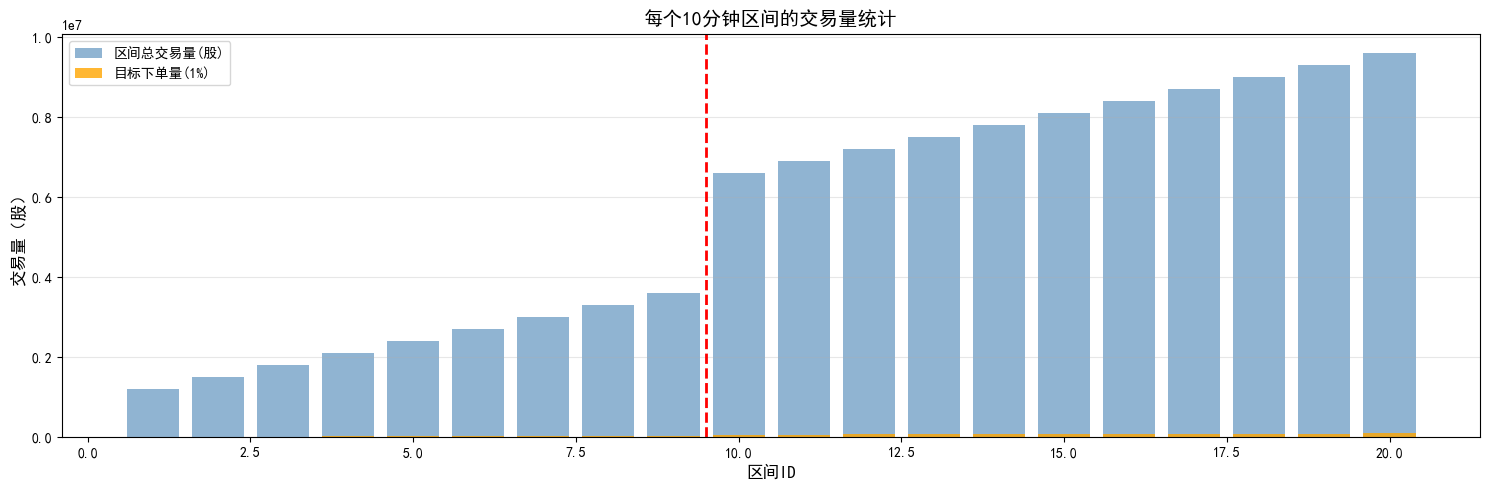

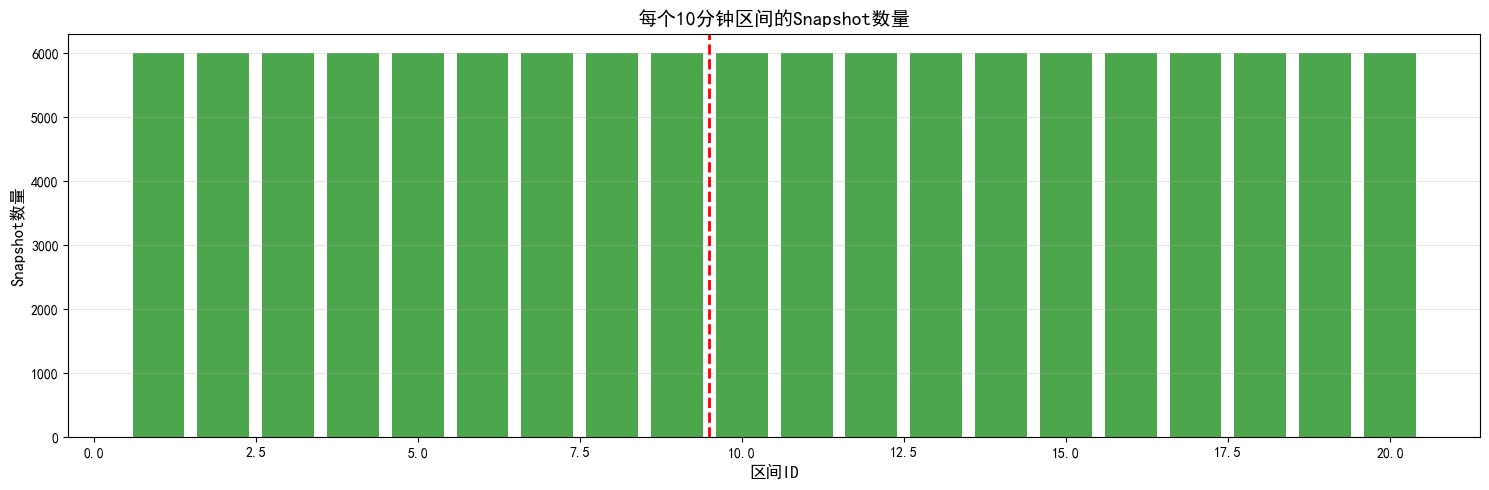

✓ 图表已保存为 interval_volume_analysis_1.png 和 interval_volume_analysis_2.png


In [15]:
# 注意：如果matplotlib有问题，请先修复matplotlib再运行此cell
# 修复方法见 修复matplotlib.md 文件

try:
    # 图1：总交易量和目标下单量
    plt.figure(figsize=(15, 5))
    x = interval_stats['interval_id']
    plt.bar(x, interval_stats['interval_total_volume'], alpha=0.6, label='区间总交易量(股)', color='steelblue')
    plt.bar(x, interval_stats['target_order_volume'], alpha=0.8, label='目标下单量(1%)', color='orange')
    plt.xlabel('区间ID', fontsize=12)
    plt.ylabel('交易量（股）', fontsize=12)
    plt.title('每个10分钟区间的交易量统计', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    # 在上午和下午之间添加分隔线
    plt.axvline(x=9.5, color='red', linestyle='--', linewidth=2)
    plt.tight_layout()
    plt.savefig('interval_volume_analysis_1.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 图2：snapshot数量
    plt.figure(figsize=(15, 5))
    plt.bar(x, interval_stats['snapshot_count'], alpha=0.7, color='green')
    plt.xlabel('区间ID', fontsize=12)
    plt.ylabel('Snapshot数量', fontsize=12)
    plt.title('每个10分钟区间的Snapshot数量', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    plt.axvline(x=9.5, color='red', linestyle='--', linewidth=2)
    plt.tight_layout()
    plt.savefig('interval_volume_analysis_2.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ 图表已保存为 interval_volume_analysis_1.png 和 interval_volume_analysis_2.png")

except ImportError as e:
    print("❌ Matplotlib导入错误！")
    print(f"错误信息: {e}")
    print("\n解决方法：")
    print("1. 在终端（不是notebook）运行：")
    print("   pip uninstall matplotlib -y")
    print("   pip install matplotlib")
    print("\n2. 重启Jupyter notebook和kernel")
    print("\n3. 重新运行此cell")
    print("\n详细修复步骤请查看 修复matplotlib.md 文件")


### 10.2 价差分析


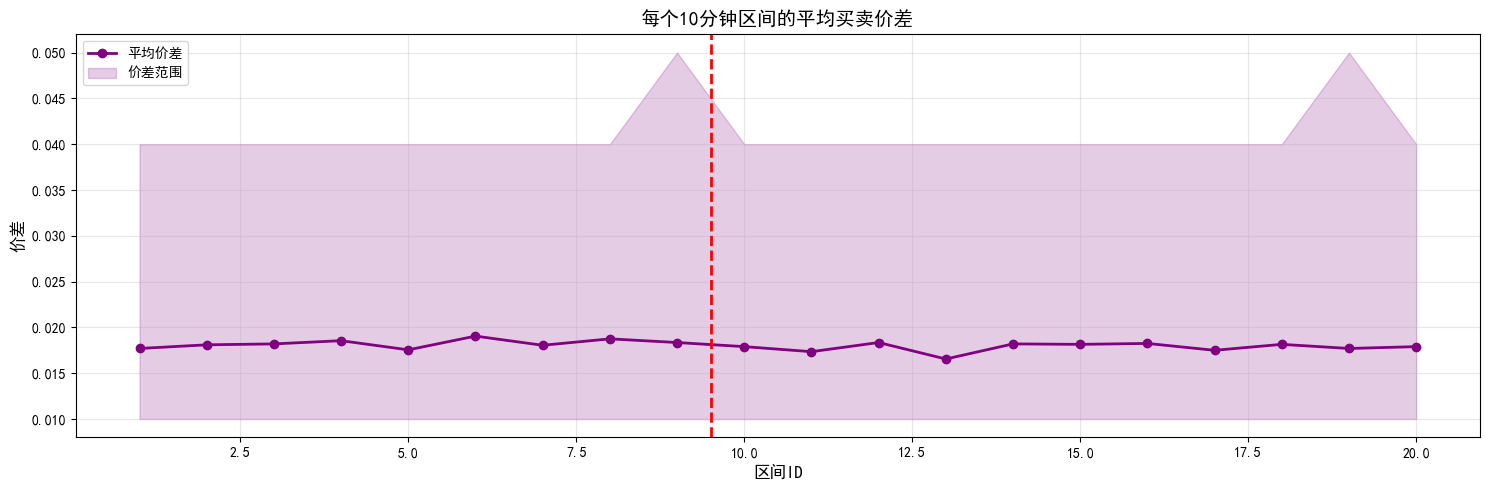

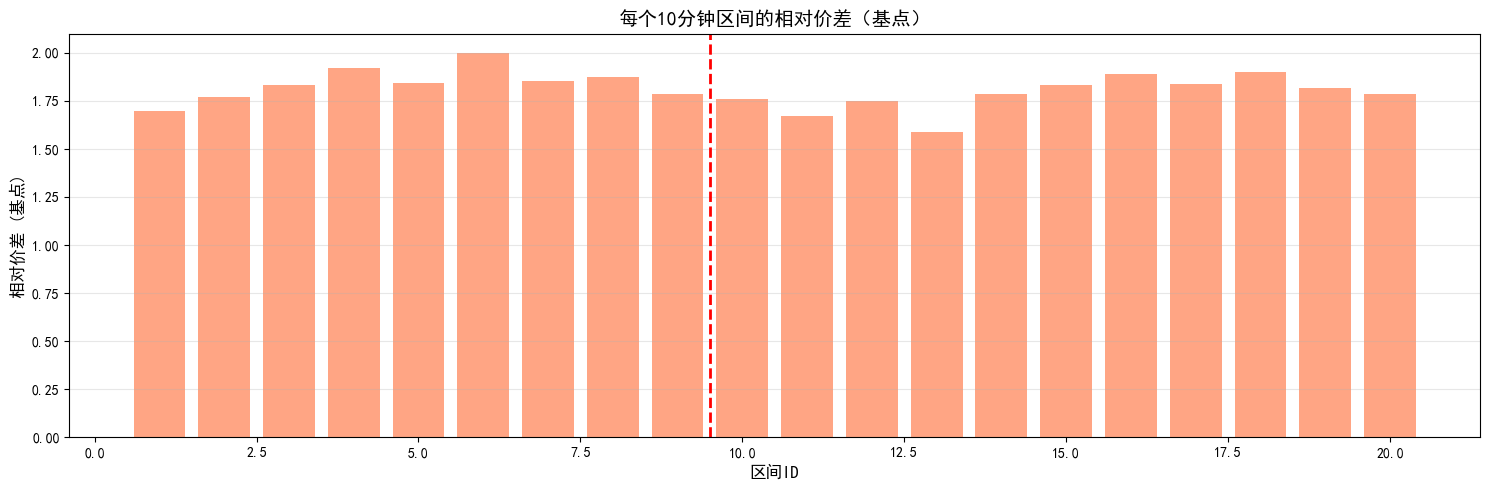

✓ 图表已保存为 interval_spread_analysis_1.png 和 interval_spread_analysis_2.png


In [16]:
# 计算每个区间的平均价差
spread_by_interval = df_final.groupby('interval_id').agg({
    'spread': ['mean', 'std', 'min', 'max'],
    'spread_bps': ['mean', 'std']
}).reset_index()

spread_by_interval.columns = ['interval_id', 'spread_mean', 'spread_std', 
                                'spread_min', 'spread_max', 'spread_bps_mean', 'spread_bps_std']

# 图1：平均价差
plt.figure(figsize=(15, 5))
plt.plot(spread_by_interval['interval_id'], spread_by_interval['spread_mean'], 
         marker='o', linewidth=2, markersize=6, color='purple', label='平均价差')
plt.fill_between(spread_by_interval['interval_id'], 
                  spread_by_interval['spread_min'], 
                  spread_by_interval['spread_max'], 
                  alpha=0.2, color='purple', label='价差范围')
plt.xlabel('区间ID', fontsize=12)
plt.ylabel('价差', fontsize=12)
plt.title('每个10分钟区间的平均买卖价差', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.axvline(x=9.5, color='red', linestyle='--', linewidth=2)
plt.tight_layout()
plt.savefig('interval_spread_analysis_1.png', dpi=300, bbox_inches='tight')
plt.show()

# 图2：相对价差（基点）
plt.figure(figsize=(15, 5))
plt.bar(spread_by_interval['interval_id'], spread_by_interval['spread_bps_mean'], 
        alpha=0.7, color='coral')
plt.xlabel('区间ID', fontsize=12)
plt.ylabel('相对价差 (基点)', fontsize=12)
plt.title('每个10分钟区间的相对价差（基点）', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.axvline(x=9.5, color='red', linestyle='--', linewidth=2)
plt.tight_layout()
plt.savefig('interval_spread_analysis_2.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 图表已保存为 interval_spread_analysis_1.png 和 interval_spread_analysis_2.png")


### 10.3 中间价走势


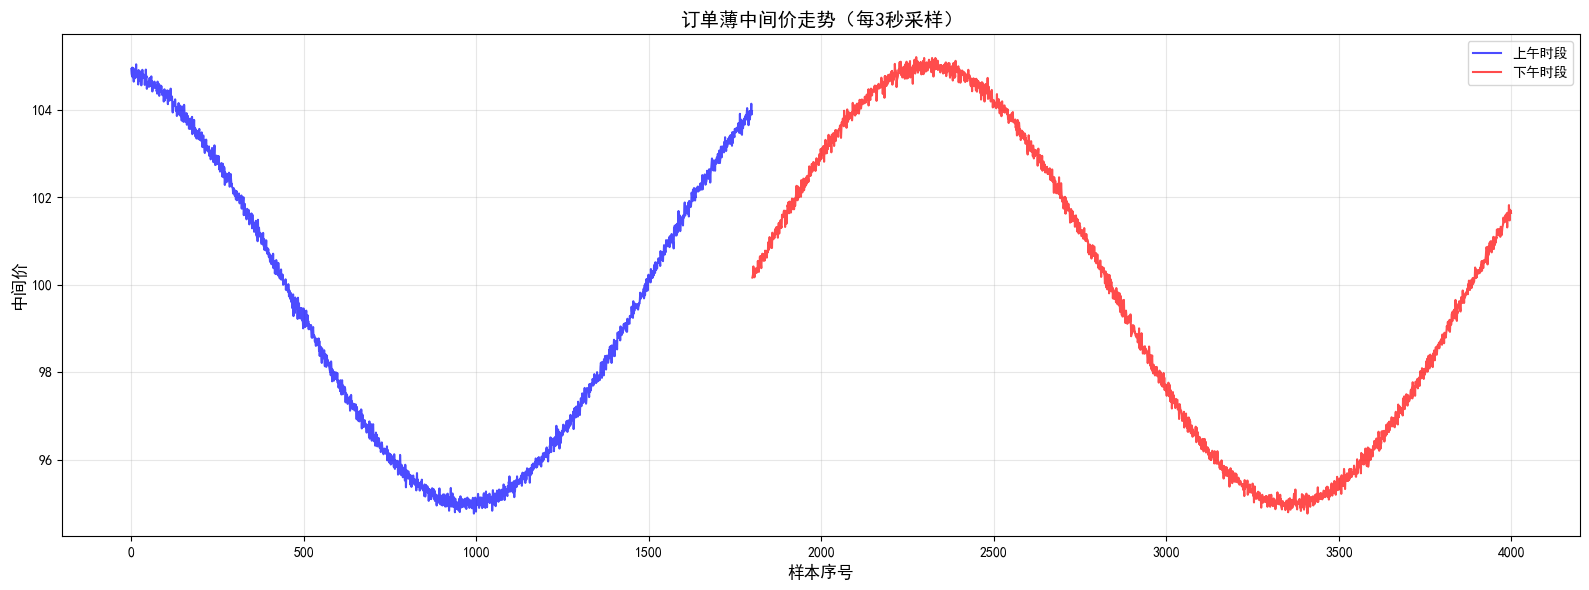

✓ 图表已保存为 mid_price_trend.png


In [17]:
fig, ax = plt.subplots(figsize=(16, 6))

# 为不同时段使用不同颜色
morning_data = df_final[df_final['session'] == '上午']
afternoon_data = df_final[df_final['session'] == '下午']

ax.plot(morning_data.index, morning_data['mid_price'], 
        linewidth=1.5, color='blue', label='上午时段', alpha=0.7)
ax.plot(afternoon_data.index, afternoon_data['mid_price'], 
        linewidth=1.5, color='red', label='下午时段', alpha=0.7)

ax.set_xlabel('样本序号', fontsize=12)
ax.set_ylabel('中间价', fontsize=12)
ax.set_title('订单薄中间价走势（每3秒采样）', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('mid_price_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 图表已保存为 mid_price_trend.png")


### 10.4 汇总统计表


In [17]:
print("=" * 100)
print("数据处理汇总")
print("=" * 100)
print(f"\n1. 基本信息:")
print(f"   - 总区间数: {len(interval_stats)}")
print(f"   - 上午区间: {len(interval_stats[interval_stats['session']=='上午'])}")
print(f"   - 下午区间: {len(interval_stats[interval_stats['session']=='下午'])}")
print(f"   - 总snapshot数: {len(df_final)}")
print(f"   - 平均每区间snapshot数: {len(df_final) / len(interval_stats):.1f}")

print(f"\n2. 交易量统计:")
print(f"   - 各区间总交易量之和: {interval_stats['interval_total_volume'].sum():,.0f} 股")
print(f"   - 各区间总交易额之和: {interval_stats['total_amount'].sum():,.2f} 元")
print(f"   - 总目标下单量(1%): {interval_stats['target_order_volume'].sum():,.2f} 股")
print(f"   - 平均每区间交易量: {interval_stats['interval_total_volume'].mean():,.1f} 股")
print(f"   - 平均每区间交易额: {interval_stats['total_amount'].mean():,.2f} 元")

print(f"\n3. 价差统计:")
print(f"   - 平均价差: {df_final['spread'].mean():.4f}")
print(f"   - 价差标准差: {df_final['spread'].std():.4f}")
print(f"   - 平均相对价差: {df_final['spread_bps'].mean():.2f} bp")
print(f"   - 中间价范围: [{df_final['mid_price'].min():.2f}, {df_final['mid_price'].max():.2f}]")

print(f"\n4. 字段说明:")
print(f"   - volume: 累计成交量（整数，股数）")
print(f"   - amount: 累计成交额（浮点数，金额）")
print(f"   - interval_total_volume: 每个区间的总成交量")
print(f"   - target_order_volume: 目标下单量（区间总成交量的1%）")

print("\n" + "=" * 100)
print("✓ 所有数据处理完成！")
print("=" * 100)


数据处理汇总

1. 基本信息:
   - 总区间数: 20
   - 上午区间: 9
   - 下午区间: 11
   - 总snapshot数: 4000
   - 平均每区间snapshot数: 200.0

2. 交易量统计:
   - 各区间总交易量之和: 110,699,939 股
   - 各区间总交易额之和: 64,367,834,705,769.93 元
   - 总目标下单量(1%): 1,106,999.39 股
   - 平均每区间交易量: 5,534,997.0 股
   - 平均每区间交易额: 3,218,391,735,288.50 元

3. 价差统计:
   - 平均价差: 0.0180
   - 价差标准差: 0.0073
   - 平均相对价差: 1.81 bp
   - 中间价范围: [94.78, 105.20]

4. 字段说明:
   - volume: 累计成交量（整数，股数）
   - amount: 累计成交额（浮点数，金额）
   - interval_total_volume: 每个区间的总成交量
   - target_order_volume: 目标下单量（区间总成交量的1%）

✓ 所有数据处理完成！


## 11. 查看特定区间的详细数据


In [18]:
# 选择一个区间查看详细信息（例如区间1）
selected_interval = 1

print(f"区间 {selected_interval} 的详细信息：\n")
print("=" * 80)
print("区间统计信息:")
print("=" * 80)
interval_info = interval_stats[interval_stats['interval_id'] == selected_interval]
print(interval_info[['interval_id', 'session', 'snapshot_count', 'interval_total_volume', 
                      'target_order_volume', 'total_amount']])

print(f"\n" + "=" * 80)
print(f"Snapshot详细数据（前20条）:")
print("=" * 80)
interval_snapshots = df_final[df_final['interval_id'] == selected_interval]
print(interval_snapshots[['timestamp', 'bid1_p', 'ask1_p', 'spread', 'mid_price', 
                           'volume', 'amount', 'target_order_volume']].head(20))

print(f"\n" + "=" * 80)
print(f"该区间汇总:")
print(f"  - Snapshot总数: {len(interval_snapshots)}")
print(f"  - 区间总成交量: {interval_info['interval_total_volume'].values[0]:,.0f} 股")
print(f"  - 目标下单量(1%): {interval_info['target_order_volume'].values[0]:,.2f} 股")
print(f"  - 区间总成交额: {interval_info['total_amount'].values[0]:,.2f} 元")
print("=" * 80)


区间 1 的详细信息：

区间统计信息:
   interval_id session  snapshot_count  interval_total_volume  target_order_volume  total_amount
0            1      上午            6000                1199994             11999.94  6.565809e+11

Snapshot详细数据（前20条）:
             timestamp  bid1_p  ask1_p  spread  mid_price  volume       amount  target_order_volume
0  2025-12-20 10:00:00  104.92  104.94    0.02    104.930  900042  94439633.33             11999.94
1  2025-12-20 10:00:03  104.80  104.83    0.03    104.815  901546  94494535.54             11999.94
2  2025-12-20 10:00:06  104.77  104.78    0.01    104.775  903046  94613690.59             11999.94
3  2025-12-20 10:00:09  104.95  104.97    0.02    104.960  904547  94940428.82             11999.94
4  2025-12-20 10:00:12  104.73  104.75    0.02    104.740  906053  94897646.94             11999.94
5  2025-12-20 10:00:15  104.88  104.89    0.01    104.885  907552  95188465.78             11999.94
6  2025-12-20 10:00:18  104.94  104.95    0.01    104.945  90903

## 12. 导出数据用于TWAP交易模拟

现在数据已经按10分钟区间组织好，每个区间包含：
- 每3秒的orderbook snapshot
- 该区间的总交易量和目标下单量（1%）
- 市场指标（价差、中间价等）

可以在`twap_execution.py`中使用这些数据进行TWAP交易模拟


In [19]:
print("数据已准备完毕，可以用于TWAP交易分析：")
print(f"\n主数据集: orderbook_sampled_10min_intervals.parquet")
print(f"  - {len(df_final)} 条snapshot记录")
print(f"  - 包含字段: {list(df_final.columns)}")

print(f"\n统计数据集: interval_statistics.parquet / interval_statistics.csv")
print(f"  - {len(interval_stats)} 个区间统计")
print(f"  - 包含字段: {list(interval_stats.columns)}")


数据已准备完毕，可以用于TWAP交易分析：

主数据集: orderbook_sampled_10min_intervals.parquet
  - 4000 条snapshot记录
  - 包含字段: ['timestamp', 'symbol', 'bid1_p', 'bid1_v', 'bid2_p', 'bid2_v', 'bid3_p', 'bid3_v', 'bid4_p', 'bid4_v', 'bid5_p', 'bid5_v', 'ask1_p', 'ask1_v', 'ask2_p', 'ask2_v', 'ask3_p', 'ask3_v', 'ask4_p', 'ask4_v', 'ask5_p', 'ask5_v', 'last_price', 'volume', 'amount', 'time', 'interval_id', 'spread', 'mid_price', 'spread_bps', 'session', 'snapshot_count', 'interval_total_volume', 'target_order_volume', 'total_amount']

统计数据集: interval_statistics.parquet / interval_statistics.csv
  - 20 个区间统计
  - 包含字段: ['interval_id', 'snapshot_count', 'total_volume', 'avg_volume', 'std_volume', 'total_amount', 'avg_amount', 'start_time', 'end_time', 'interval_total_volume', 'target_order_volume', 'session']
